# A data-driven approach to predict the success of bank telemarketing 

### Part 2: Clustering and Manifold Learning

Student Name: Paul Fagan

Student Number: 23254777

### **Data Dictionary**

Input variables:

**bank client data:**
- age (numeric)
- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
- education (categorical: "unknown","secondary","primary","tertiary")
- default: has credit in default? (binary: "yes","no")
- balance: average yearly balance, in euros (numeric) 
- housing: has housing loan? (binary: "yes","no")
- loan: has personal loan? (binary: "yes","no")

**related with the last contact of the current campaign:**
- contact: contact communication type (categorical: "unknown","telephone","cellular") 
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- duration: last contact duration, in seconds (numeric)

**other attributes:**
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
- subscribed: has the client subscribed a term deposit? (binary: "yes","no")

# Insight and Recommendations

**Summary:** 

- There is an argument for selecting 2-3 clusters in our dataset based on using K-means and DBSCAN. However, disagreement in our various scoring methods makes it difficult to make a solid recommendation on the existence of well-separated clusters. 

**Evidence**

- Positive K-Means clustering scoring (Silhouette) and visually representation via TSNE and MDS show 2 clusters, 1 very pronouced cluster and another more sparse cluster. The clusters are very tightly grouped together perhaps this highlights the clusters similarity to one another. However, our optimal K from Kneed is 5 and  purely judged by inertia is 10. Disagreement on ideal cluster numbers (2 or 5 or 10) makes it difficult to be confident in ideal clusters. 

- Our visualiation techiques based on The DBSCAN show 3 distinct dense clusters ,however this is in the face of a negative silhouette score. Even when we loop through various parameters we only negative scores suggesting weak clustering.



### Next Steps
 - Work with product and marketing teams to see if clusters profiles align with their domain knowledge and expectations.  We will prioritize their recommendation on the specific number of clusters given our work so far


 

### A. Import Python Modules and Dataset

In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

!pip install feature-engine

from feature_engine.creation import CyclicalFeatures

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, TSNE
!pip install kneed
from kneed import KneeLocator


#### Load the dataset

In [471]:
df = pd.read_csv('bank.csv')

In [472]:
df.head(5)

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1988 non-null   float64
 1   job         1990 non-null   object 
 2   marital     2000 non-null   object 
 3   education   1896 non-null   object 
 4   default     2000 non-null   object 
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   object 
 7   loan        2000 non-null   object 
 8   contact     1809 non-null   object 
 9   day         2000 non-null   int64  
 10  month       2000 non-null   object 
 11  duration    2000 non-null   int64  
 12  campaign    2000 non-null   int64  
 13  pdays       2000 non-null   int64  
 14  previous    2000 non-null   int64  
 15  poutcome    1546 non-null   object 
 16  subscribed  2000 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 265.8+ KB


### Task 1: Data Preparation Pipeline


The steps: 
- Define sets of columns to be transformed in different ways e.g categorical and numerical columns. 
- Create Pipelines for Numerical and Categorical Features
    - Pipeline(steps = [(‘step name’, transform function), …])
    -  - MinMaxScaler or StandardScaler to the  columns without outliers and RobustScaler to columns with outliers
    - For numerical features:
        - SimpleImputer to fill in the missing values with the mean of that column.
        - MinMaxScaler to scale the value to range from 0 to 1 (this will affect regression performance).
    - For categorical features
        - SimpleImputer to fill in the missing values with the most frequency value of that column.
        - OneHotEncoder to split to many numerical columns for model training. (handle_unknown=’ignore’ is specified to prevent errors when it finds an unseen category in the test set)
- Create ColumnTransformer to apply pipeline for cat and num
    - ColumnTransformer(transformers=[(‘step name’, transform function,cols), …])

- Add a model to a final pipeline
- Display the pipeline

#### 1.1 Define sets of columns to be transformed 

A big decision I need to make is whether to create pipelines which group numerous columns or to create seperate pipelines for each column as done so by Rui Lima and Jason Coleman. 

**Numerical columns**

In [474]:
# Get numerical columns excluding those containing 'day'
num_cols = [col for col in df.select_dtypes(include=['float64', 'int64'])]


num_cols.remove('day')
    
print("Numerical Variables:")
for col in num_cols:
    print(col)


Numerical Variables:
age
balance
duration
campaign
pdays
previous


In [475]:
# I want to create seperate columns with outliers from those without

data = df
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers


# Identify numerical variables with outliers
variables_with_outliers = []
for var in num_cols:
    if detect_outliers_iqr(df[var]).any():
        variables_with_outliers.append(var)

# Print the list of numerical variables with outliers
print("Numerical variables with outliers:")
for var in variables_with_outliers:
    print(var)

Numerical variables with outliers:
balance
duration
campaign
pdays
previous


In [476]:
# Calculate the remaining columns (numerical variables without outliers)
num_cols_withoutliers = list(set(numerical_variables) - set(variables_with_outliers))

num_cols_withoutliers.remove('day')

print("Numberical variables (without outliers):")
for col in num_cols_withoutliers:
    print(col)

Numberical variables (without outliers):
age


**Categorical columns**

In [477]:
# Get categorical columns excluding 'subscribed' and columns containing 'month'
cat_cols = [col for col in df.select_dtypes(include=['object']).columns if col != 'subscribed' and 'month' not in col.lower()]

# Print categorical variables
print("Categorical Variables:")
for col in cat_cols:
    print(col)


Categorical Variables:
job
marital
education
default
housing
loan
contact
poutcome


**Cycical columns**

In [478]:
class CyclicalFeatureTransformer(BaseEstimator, TransformerMixin):
    def month_to_num(self, month):
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        return months.index(month.lower()) + 1

    def create_cyclical_features(self, X, col, max_val):
        X[col + '_sin'] = np.sin(2 * np.pi * X[col] / max_val)
        X[col + '_cos'] = np.cos(2 * np.pi * X[col] / max_val)
        return X

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['month_num'] = X['month'].apply(self.month_to_num)
        X = self.create_cyclical_features(X, 'month_num', 12)
        X_transformed = X.copy()
        X_transformed.drop(columns=['month', 'month_num'], axis=1, inplace=True)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return ['month_sin', 'month_cos']

#### 1.2 Create Pipelines for all  Features

In [479]:
num_outlier_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale',RobustScaler())
])

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])


cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])


month_pipeline = Pipeline([
    ('cyclical_month', ColumnTransformer([
        ('cyclical_month', CyclicalFeatureTransformer(), ['month'])
    ], remainder='passthrough'))
])



#### 1.3 Create ColumnTransformer to Apply the Pipeline for Each Column Set

In [480]:
# Main preprocessing pipeline
col_trans = ColumnTransformer(transformers=[
    ('num_pipe',num_pipe,['age']),('num_outlier',num_outlier_pipe,variables_with_outliers),
    ('cat_pipe',cat_pipe,cat_cols),('month_pipe',month_pipeline,['month'])
    ],
    remainder='drop',
    n_jobs=-1)

In [481]:
set_config(display='diagram')
display(col_trans)

ColumnTransformer(n_jobs=-1,
                  transformers=[('num_pipe',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', MinMaxScaler())]),
                                 ['age']),
                                ('num_outlier',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', RobustScaler())]),
                                 ['balance', 'duration', 'campaign', 'pdays',
                                  'previous']),
                                ('cat_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'poutcome']),
                                ('month_pipe',
                                 Pipeline(steps=[('cyclical_month',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('cyclical_month',
                                                                                   CyclicalFeatureTransformer(),
                                                                                   ['month'])]))]),
                                 ['month'])])

#### 1.4 Transform the data

In [482]:
X_transformed = col_trans.fit_transform(df)

/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [483]:
# Convert the transformed array to a DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=col_trans.get_feature_names_out())

# Check for missing values in the transformed DataFrame
missing_values = X_transformed_df.isnull().sum()
print("Missing Values in Transformed Data:")
print(missing_values)


Missing Values in Transformed Data:
num_pipe__age                            0
num_outlier__balance                     0
num_outlier__duration                    0
num_outlier__campaign                    0
num_outlier__pdays                       0
num_outlier__previous                    0
cat_pipe__job_admin.                     0
cat_pipe__job_blue-collar                0
cat_pipe__job_entrepreneur               0
cat_pipe__job_housemaid                  0
cat_pipe__job_management                 0
cat_pipe__job_retired                    0
cat_pipe__job_self-employed              0
cat_pipe__job_services                   0
cat_pipe__job_student                    0
cat_pipe__job_technician                 0
cat_pipe__job_unemployed                 0
cat_pipe__marital_divorced               0
cat_pipe__marital_married                0
cat_pipe__marital_single                 0
cat_pipe__education_primary              0
cat_pipe__education_secondary            0
cat_pipe__educatio

# Clustering techniques 

Our goal is to discover potentially unqiue and important groups within our dataset. We'll look at two techiques:

- K-Means: K-means tries to aggregate similar objects into groups called clusters. 

- Density-Based Spatial Clustering of Applications with Noise (DBSCAN): Tries to cluster based on Density,  interpreted as the concentration of the samples present in a region.



### Task 2: k-Means



The steps involved in K-means Clustering are:

- Choose the number of clusters K
- Initialize the centroids 
- Assign each data point to the closest centroid.
- Update the centroid by taking the mean of the cluster.
- Repeat steps 3 and 4 until convergence i.e No discernible change in centroids is observed.

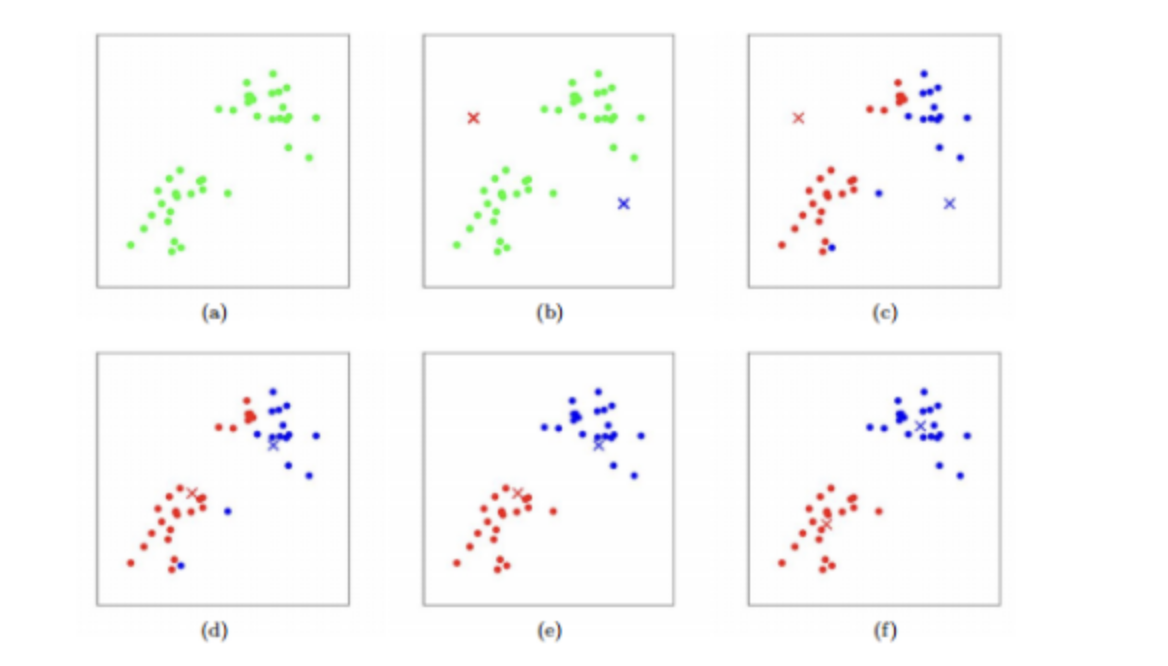

 #### 2.1 The Elbow Method

Iterate for a range of Ks and fit the scaled data to the algorithm. 


In [484]:
def plot_elbow_method(data, max_k):
    sse=[]
    for k in range (1, max_k+1):
        kmeans= KMeans(n_clusters=k, random_state = 42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.plot(range(1, max_k + 1), sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Sum of Squared Distances vs Number of Clusters (k)')
    plt.show()

#### 2.2 The Silhouette Coefficient 

Next I created a similar loop to iterate through the data and produce a Silhouette Coefficient to measures how well data points are clustered. 

- It considers two distances:
  - How far a point is from its own cluster (average distance).
  - How far it is to the closest different cluster.

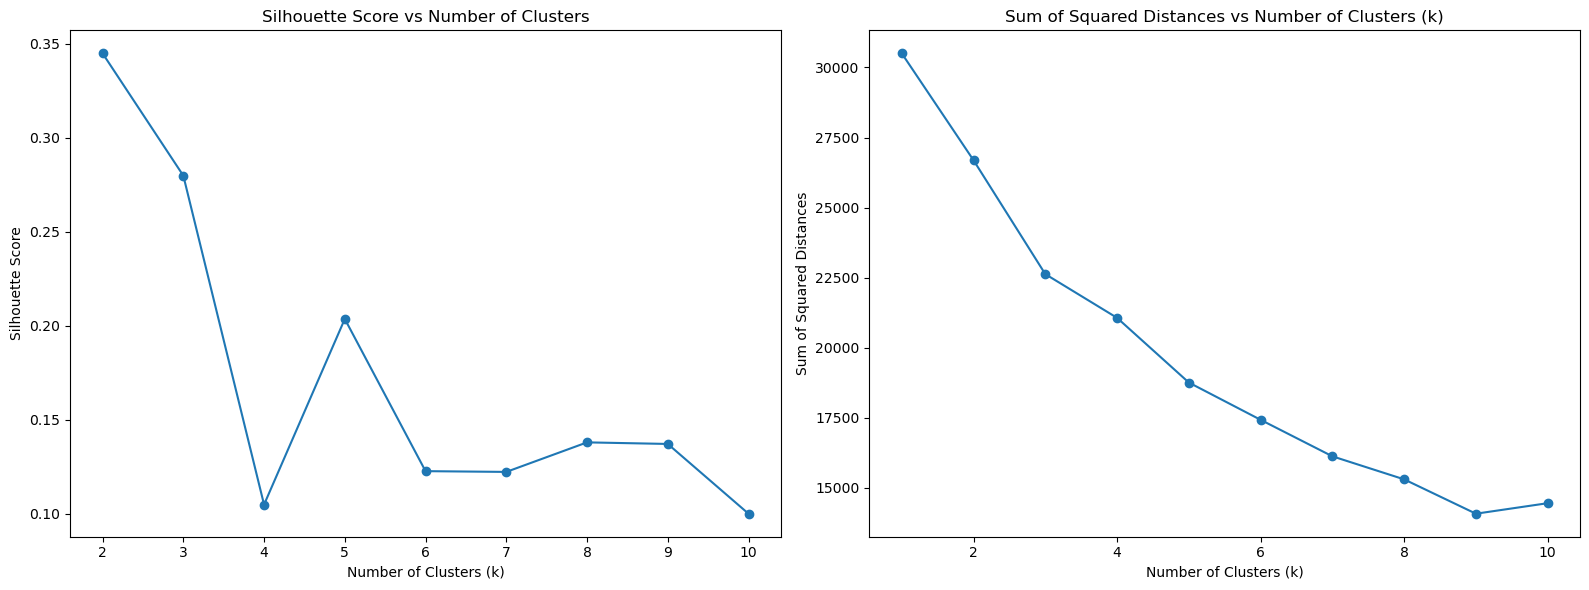

Best Silhouette Score: 0.34488559167033894
Best Number of Clusters (k): 2


In [485]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def find_best_k(data, max_k):
    silhouette_scores = []
    sse = []  # To store sum of squared distances

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        if k > 1:
            silhouette_score_val = silhouette_score(data, kmeans.labels_)
            silhouette_scores.append(silhouette_score_val)
        
        sse.append(kmeans.inertia_)  # Append sum of squared distances

    # Plotting both silhouette score and SSE
    plt.figure(figsize=(16, 6))
    
    # Plot Silhouette Score vs Number of Clusters
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')  # Use range(2, max_k + 1) for correct indexing
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    
    # Plot SSE vs Number of Clusters
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_k + 1), sse, marker='o')  # Use range(1, max_k + 1) for correct indexing
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Sum of Squared Distances vs Number of Clusters (k)')
    
    plt.tight_layout()
    plt.show()
    
    # Determine the best k based on silhouette score
    best_k_index = np.argmax(silhouette_scores) + 2  # Adjusted for range starting from 2
    best_silhouette_score = silhouette_scores[best_k_index - 2]
    
    return best_silhouette_score, best_k_index


best_silhouette_score, best_k_index = find_best_k(X_transformed_df, max_k=10)
print("Best Silhouette Score:", best_silhouette_score)
print("Best Number of Clusters (k):", best_k_index)


#### 2.2.1 the kneedle algorithm

Another way to discover the elbow or 'Knee-point' is the kneedle algorithm.  

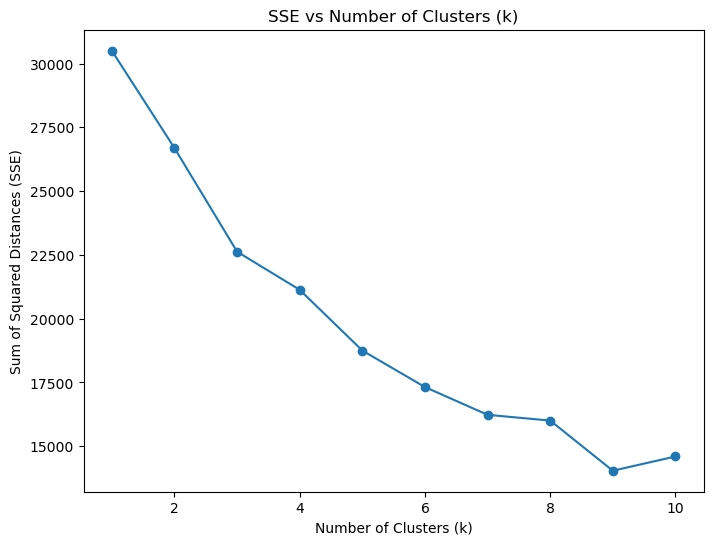

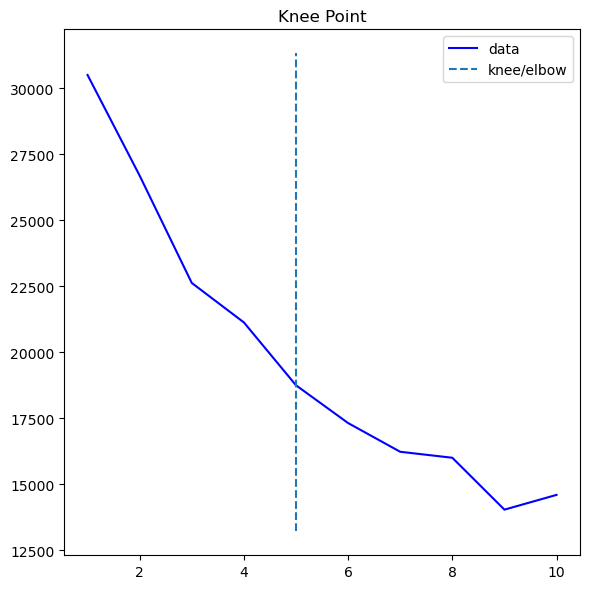

In [486]:
def find_best_k_kneed(data, max_k):
    sse = []  # To store sum of squared distances

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # Append sum of squared distances

    # Plot SSE vs Number of Clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (SSE)')
    plt.title('SSE vs Number of Clusters (k)')

    # Add KneeLocator plot to identify the elbow point
    kl = KneeLocator(range(1, max_k + 1), sse, curve='convex', direction='decreasing')
    kl.plot_knee()

    plt.tight_layout()
    plt.show()

    # Return the KneeLocator object for further analysis
    return kl

# Example usage:
kl = find_best_k_kneed(X_transformed_df, max_k=10)


**Observations**

**plot 1: Silhouette Score vs Number of Clusters**
- The Best Number of Clusters (k) using the highest Silhouette score is:  2
- The Silhouette Coefficient for the fully transformed data is 0.65, indictating strong clustering quality
- In general, the Silhouette  Coefficient ranges from −1 to +1 where  in higher coefficients points are closer within their cluster and farther from other clusters. 
    

**plot 2: SSE vs Number of Clusters**
- Visually, we can see from the SSE plot that there are sharp drops and dip from ~2 and beyond and there doesn't seem to be a clear 'elbow' . 


**plot 3: Knee plot** 
- The kneed package produces  (k): 4 and is considered a more objective approach. It also aligns more closely with the visual. 

**Overall, we can choose between 2 and 4 clusters.** 


**Experiment: Remove one-hot encoding**


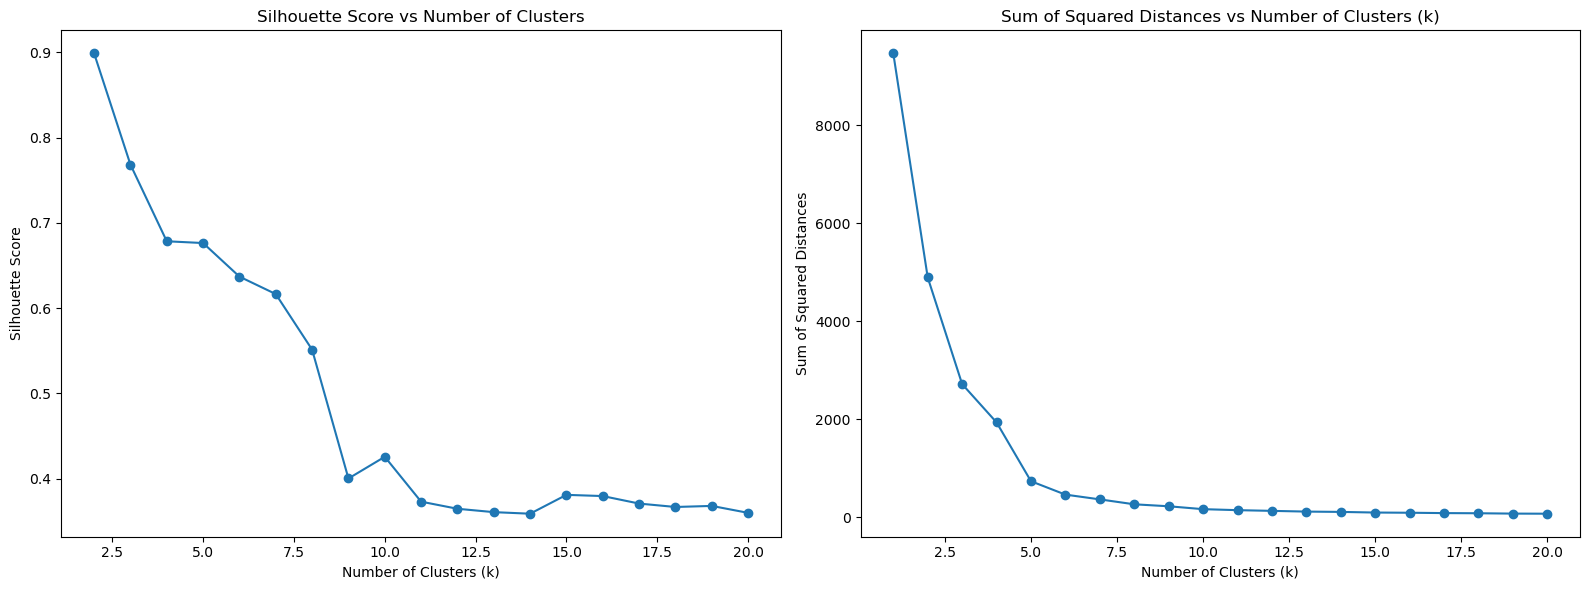

(0.8987523483489182, 2)

In [487]:
numerical_data_trans = X_transformed[:, :len(col_trans.transformers_[0:2])] 

find_best_k(numerical_data_trans, max_k=20)

**Observations**

- The experiment removing one-hot encoding was much higher 0.89 indictating excellent clustering quality and  recommends the Best Number of Clusters (k) is 2

## 2.3 perform K-means with k=2

- Perform clustering (e.g., K-means) to group similar data points into clusters based on feature similarity.

- Use dimensionality reduction techniques like MDS or t-SNE to project the clustered data into 2D or 3D space for visualization.

**2.3.1  Utiliy function** 

In [488]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

**2.3.2  Define the pipeline, with kmeans**

In [489]:
k = 2

pipe = Pipeline(steps=[
    ('preprocess', col_trans), 
    ('kMeans', KMeans(n_clusters=k, n_init=10, max_iter=300))
])

**2.3.3  Define the pipeline, with kmeans**

In [490]:
clustering_model = pipe.fit(df)
clustering_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('num_outlier',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('i...
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('month_pipe',
                                                  Pipeline(steps=[('cyclical_month',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical_month',
                                                                                                    CyclicalFeatureTransformer(),
                                                                                                    ['month'])]))]),
                                                  ['month'])])),
                ('kMeans', KMeans(n_clusters=2, n_init=10))])

**Double check labels**

In [491]:
# Get cluster labels from the K-means model
kmeans_model = clustering_model.named_steps['kMeans']
cluster_labels = kmeans_model.labels_

# Find the number of unique cluster labels
unique_labels = np.unique(cluster_labels)
num_unique_labels = len(unique_labels)

print("Unique Cluster Labels:", unique_labels)
print("Number of Unique Cluster Labels:", num_unique_labels)

Unique Cluster Labels: [0 1]
Number of Unique Cluster Labels: 2


**2.3.4 Select the transformed data**

In [492]:
preprocessed_data = clustering_model['preprocess'].transform(df)
preprocessed_data

array([[ 1.86666667e-01, -1.10187110e-01,  3.09442060e+00, ...,
         0.00000000e+00,  8.66025404e-01, -5.00000000e-01],
       [ 2.80000000e-01,  9.49410949e-02, -1.28755365e-02, ...,
         0.00000000e+00,  8.66025404e-01, -5.00000000e-01],
       [ 5.46666667e-01,  3.35412335e-01, -4.72103004e-01, ...,
         0.00000000e+00,  8.66025404e-01, -5.00000000e-01],
       ...,
       [ 8.40000000e-01,  4.17879418e-01, -2.14592275e-02, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16],
       [ 3.73333333e-01,  2.62785863e+00, -2.18884120e-01, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16],
       [ 2.93333333e-01,  4.05544006e+00, -1.20171674e-01, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16]])

**2.3.5 Scoring the clusters: K-Means and Inertia**

- Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.
- A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.



In [493]:
inertia = kmeans.inertia_

print("Inertia for K-means clustering:", inertia)


Inertia for K-means clustering: 25938.84649079883


**Experiment**

 - Given lower inertia scores indicate tighter clusters,let's loop through K values,to find best corresponding lowest inertia

In [524]:
k_values = range(2, 11) 
lowest_inertia = float('inf')
best_k = None

for k in k_values:
    
    pipe_exp = Pipeline(steps=[
        ('preprocess', col_trans), 
        ('kMeans', KMeans(n_clusters=k, n_init=10, max_iter=300))
    ])
    
    
    clustering_model_exp = pipe_exp.fit(df)
    
    # Get the inertia of the current clustering
    inertia_exp = clustering_model_exp.named_steps['kMeans'].inertia_
    
    # Check if current inertia is the lowest found so far
    if inertia_exp < lowest_inertia:
        lowest_inertia = inertia_exp
        best_k = k
print("Best K for lowest inertia:", best_k)
print("Lowest Inertia:", lowest_inertia)

/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Best K for lowest inertia: 10
Lowest Inertia: 13471.621304944905


**Observations**
- The best K for lowest inertia: 10, which, unfortunately doesnt agreement with our  Silhouette scores or Kneed score. 

**Scoring the clusters: Silhouette_score**

In [494]:
silhouette_avg = silhouette_score(X_transformed, cluster_labels)
print("Silhouette Score for K-means clustering with {} clusters:".format(k), silhouette_avg)

Silhouette Score for K-means clustering with 2 clusters: 0.6525622870071792


**Observations**
- The Silhouette Score near 0 shows weak cluster separation which we can see easily in the graph below.
 - Suggested actions: Work with lower K -values. 


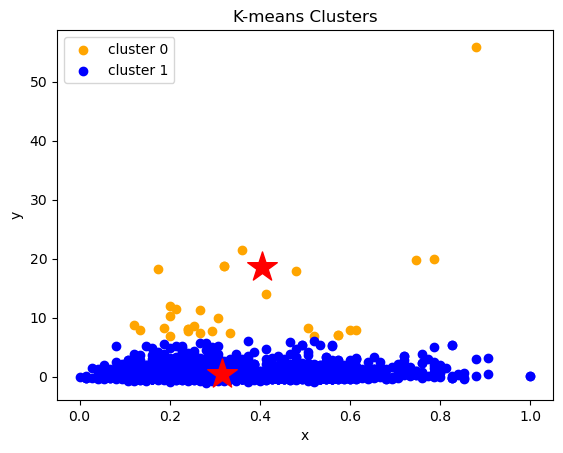

In [495]:
# basic visualisation:

clustering_scatterplot(X_transformed, cluster_labels, cluster_centroids, title='K-means Clusters')
plt.show()

**observations**
 -  We can see our two clusters and their centroids by using a regular scatterplot.
 - However, in case we can better see the structure of our clusters  we will use dimension reduction techniques 

### 2.4  Use MDS and t-SNE for visualising the clusterings

We'll use two similar types of visualisation techniques to project the data set to a 2D space: 

- Multidimensional scaling (MDS)  aims to preserve the distances between **pairs of data points** to faithfully recreate the mapping with no information loss. 


- t-SNE focuses on maintaining **neighborhood data points** so that points close to one another in high-dimensional data will be in lower dimensions .


**Which one to use?** 

- Rule of thumb: When We want to find clusters we use t-SNE and when we care about all the distances we use MDS

**2.4.1 Define and fit MDS**

In [496]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

In [497]:
from sklearn.manifold import MDS


XYcoordinates = MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
# n_components=2 refers to 2d space

print("MDS transformation complete")


MDS transformation complete


**2.4.2 visualise**

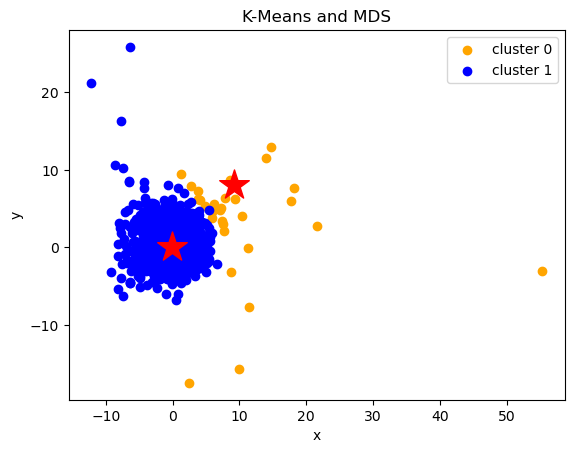

In [498]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='K-Means and MDS')

**Observations:**
- We can clearly see 1 very pronouced cluster and another more sparse cluster. 
- The clusters are very tightly grouped together perhaps this highlights the clusters similarity to one another
- [aside] The power of manifold learning is clear.   MDS does a better job at representing the clusters than a regular scatterplot 



**2.4.3 Define and fit T-SNE**

transformation complete


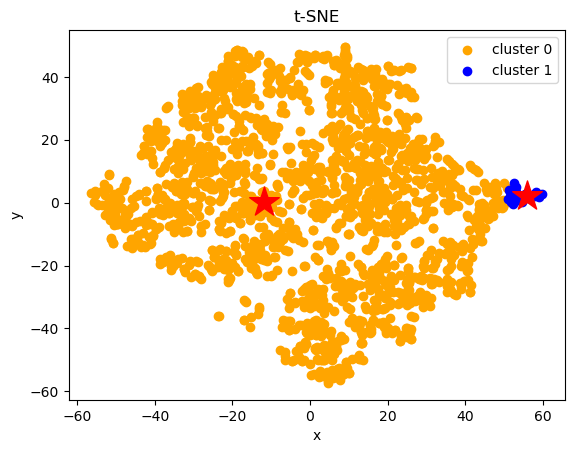

In [513]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='t-SNE')


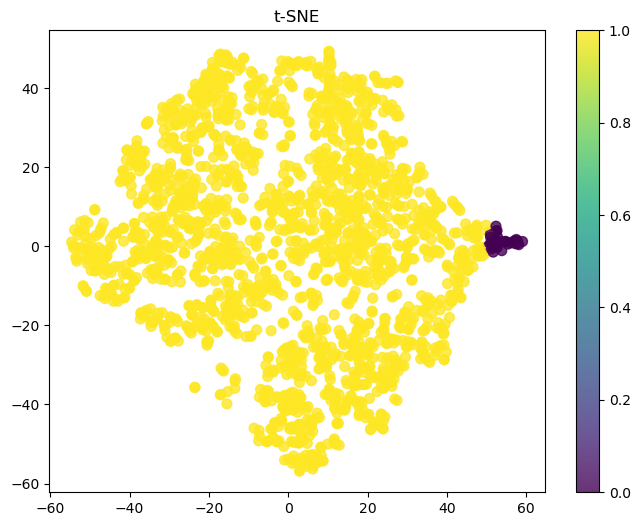

In [512]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8)
plt.title('t-SNE')
plt.colorbar()
plt.show()

**Observations:**
- T-SNE emphasises the two clusters although both look very related and almost arbitary. 
- We could easily argue for 2-4 clusters if we returning to our earlier cluster scoring. 

### Task 3: DBSCAN Approach 1

**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)** 

- epsilon (eps): It specifies how close points should be to each other to be considered as part of a cluster.

- minPoints: The minimum number of points to form a dense region. For example, minPoints =  4, then we need at least 4 points to form a dense region.


Steps in DBSCAN:

- Choose a Point: Start by picking any point in your dataset.

- Draw a Circle: Draw a circle (with radius epsilon) around this point to find its neighboring points.

- Identify Core Points: A point is called a "core" point if:

  - It's surrounded by at least the minimum number of points (minPoints).
  - These surrounding points are within the circle (epsilon) drawn around the core point.
- Forming Clusters:

    - Begin with a core point and add it to a cluster.
    - Include all other core points within the epsilon range into this cluster.
    - Extend the cluster by adding neighboring points (both core and non-core) until no more points can be added.
    - Handling Outliers: Points that do not belong to any formed cluster are treated as outliers.

In [501]:
def clustering_scatterplot_db(points, labels, title):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    for i in range(n_clusters):
        if i == -1:
            color = 'black'
            label = 'noise'
        else:
            color = colors[i % colors.size]
            label = 'cluster ' + str(i)
        h = plt.scatter(points[labels == i, 0],
                        points[labels == i, 1], 
                        c=color,
                        label=label)
    
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

**Define pipeline**

In [507]:
from sklearn.cluster import DBSCAN

pipe_DBSCAN = Pipeline(steps=[
    ('preprocess', col_trans),
    ('dbscan', DBSCAN(eps=0.5, min_samples=5))
])


**Fit pipline**

In [508]:
clustering_model_DBSCAN = pipe_DBSCAN.fit(df)

In [509]:
preprocessed_data_DBSCAN = clustering_model.named_steps['preprocess'].transform(df)
preprocessed_data_DBSCAN

/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


array([[ 1.86666667e-01, -1.10187110e-01,  3.09442060e+00, ...,
         0.00000000e+00,  8.66025404e-01, -5.00000000e-01],
       [ 2.80000000e-01,  9.49410949e-02, -1.28755365e-02, ...,
         0.00000000e+00,  8.66025404e-01, -5.00000000e-01],
       [ 5.46666667e-01,  3.35412335e-01, -4.72103004e-01, ...,
         0.00000000e+00,  8.66025404e-01, -5.00000000e-01],
       ...,
       [ 8.40000000e-01,  4.17879418e-01, -2.14592275e-02, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16],
       [ 3.73333333e-01,  2.62785863e+00, -2.18884120e-01, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16],
       [ 2.93333333e-01,  4.05544006e+00, -1.20171674e-01, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16]])

In [510]:
cluster_labels_DBSCAN = clustering_model_DBSCAN.named_steps['dbscan'].labels_

silhouette_db = silhouette_score(preprocessed_data_DBSCAN, cluster_labels_DBSCAN)

print("DBSCAN Silhouette Score:", silhouette_db)



DBSCAN Silhouette Score: -0.16383207053812862


### 3.1 Use MDS and t-SNE for visualising the clusterings

In [511]:
# Perform MDS for visualization
XYcoordinates_mds_DBSCAN = MDS(n_components=2, normalized_stress='auto').fit_transform(preprocessed_data_DBSCAN)
print("transformation complete")

transformation complete


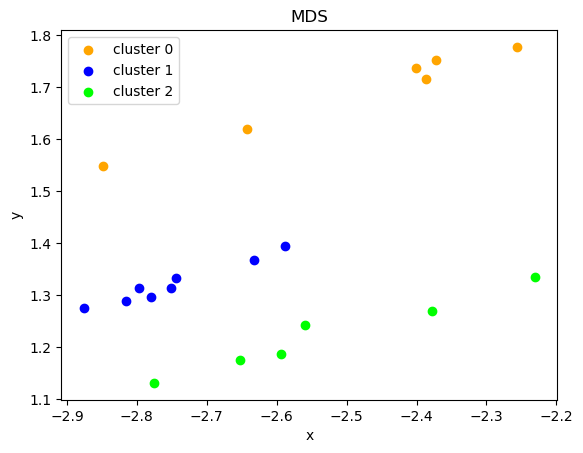

In [515]:
clustering_scatterplot_db(points=XYcoordinates_mds_DBSCAN, 
                       labels=clustering_model_DBSCAN.named_steps['dbscan'].labels_, 
                       title='MDS')

**Observations**

 - First of all, DBSCAN selects 3  clusters rather than 2, which stil agrees with our K-Means recommended clustering range of 2-4. 
 - However, the silhouette score -0.16 says otherwise that there is weak clustering
 - Visually MDS produces 3 distinct 'loins' keeping their pairwise distance relationship
 

In [516]:
# Perform t-SNE for visualization 
XYcoordinates_tsne = TSNE(n_components=2, random_state=42).fit_transform(preprocessed_data_DBSCAN)

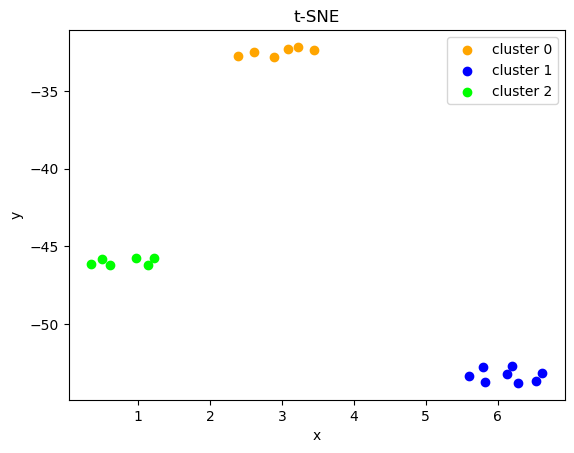

In [517]:

clustering_scatterplot_db(points=XYcoordinates_tsne, 
                       labels=clustering_model_DBSCAN.named_steps['dbscan'].labels_,
                       title='t-SNE')


**Observations**

 - T-SNE presents the 3 distinct dense clusters providing good evidence in the face of the silhouette score 

### Task 3: DBSCAN Find Optimal

Next up we run through iteration of various parameters to find the best clustering parameters. 

In [518]:
min_samples_values = [2, 4, 6, 8, 10]
eps_values = [0.1, 0.5, 1.0]


results = []


for min_samples in min_samples_values:
    for eps in eps_values:
 
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        

        cluster_labels = dbscan.fit_predict(X_transformed) 
        

        if len(set(cluster_labels)) > 1:  
            silhouette_avg = silhouette_score(X_transformed, cluster_labels)
        else:
            silhouette_avg = -1.0  
        

        results.append({
            'Min_Samples': min_samples,
            'Epsilon': eps,
            'Silhouette_Score': silhouette_avg
        })


data_frame_dbscan_iteration = pd.DataFrame(results)


print(data_frame_dbscan_iteration)


    Min_Samples  Epsilon  Silhouette_Score
0             2      0.1         -0.190144
1             2      0.5         -0.354747
2             2      1.0         -0.249184
3             4      0.1         -1.000000
4             4      0.5         -0.240470
5             4      1.0         -0.291921
6             6      0.1         -1.000000
7             6      0.5         -0.116934
8             6      1.0         -0.275901
9             8      0.1         -1.000000
10            8      0.5         -0.116934
11            8      1.0         -0.243118
12           10      0.1         -1.000000
13           10      0.5         -1.000000
14           10      1.0         -0.201085


In [520]:
best_result = data_frame_dbscan_iteration.loc[data_frame_dbscan_iteration['Silhouette_Score'].idxmax()]

print("\nBest Result:")
print(best_result)


Best Result:
Min_Samples         6.000000
Epsilon             0.500000
Silhouette_Score   -0.116934
Name: 7, dtype: float64


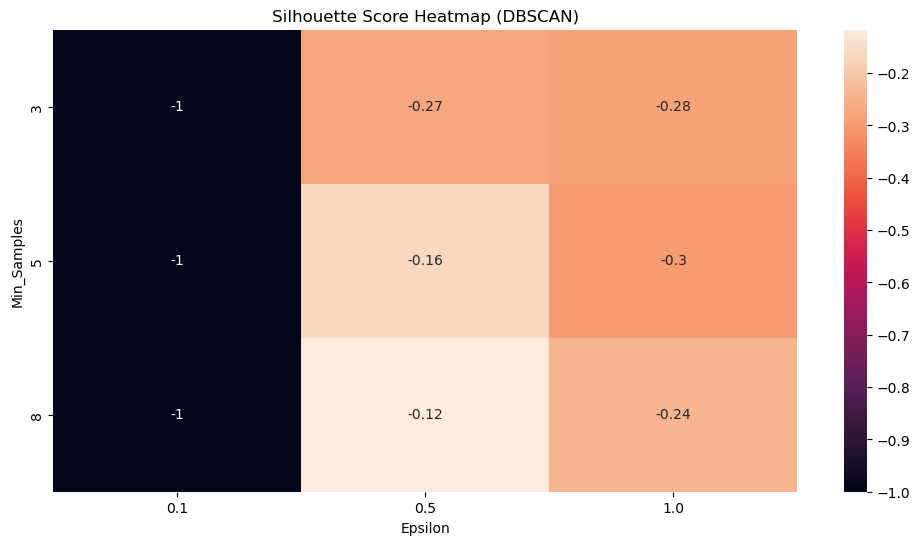

In [519]:
# Create a heatmap to visualize silhouette scores
fig, ax = plt.subplots(figsize=(12, 6))
silhouette_score_table = data_frame_dbscan_iteration_runs.pivot_table(
    values="Silhouette_Score", index="Min_Samples", columns="Epsilon"
)
sns.heatmap(silhouette_score_table, annot=True, ax=ax)

ax.set_title("Silhouette Score Heatmap (DBSCAN)")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Min_Samples")
plt.show()


**Observations**

 - Our optimal set of parameters are very close to the ones we choose to being with ,but are all still negative indicatign weak clustering.  


### Conclusion

- There is an argument for selecting 2-3 clusters in our dataset based on using K-means and DBSCAN. However, disagreement in our various scoring methods makes it difficult to make a solid recommendation on the existence of well-separated clusters. 


    - Positive K-Means clustering scoring (Silhouette) and visually representation via TSNE and MDS show 2 clusters, 1 very pronouced cluster and another more sparse cluster. The clusters are very tightly grouped together perhaps this highlights the clusters similarity to one another. However, our optimal K from Kneed is 5 and  purely judged by inertia is 10. Disagreement on ideal cluster numbers (2 or 5 or 10) makes it difficult to be confident in ideal clusters. 

    - Our visualiation techiques based on The DBSCAN show 3 distinct dense clusters ,however this is in the face of a negative silhouette score. Even when we loop through various parameters we only negative scores suggesting weak clustering.



### Next Steps
 - Work with product and marketing teams to see if clusters profiles align with their domain knowledge and expectations.  We will prioritize their recommendation on the specific number of clusters given our work so far


 
